Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch [1/15]
Loss at epoch 1 || 4.224342297744751
accuracy 10.34 percentage || Correct 1034 out of 10000 samples
Epoch [2/15]
Loss at epoch 2 || 3.577673568725586
accuracy 18.67 percentage || Correct 1867 out of 10000 samples
Epoch [3/15]
Loss at epoch 3 || 3.172475415420532
accuracy 23.49 percentage || Correct 2349 out of 10000 samples
Epoch [4/15]
Loss at epoch 4 || 2.824940196990967
accuracy 30.16 percentage || Correct 3016 out of 10000 samples
Epoch [5/15]
Loss at epoch 5 || 2.519012826347351
accuracy 33.43 percentage || Correct 3343 out of 10000 samples
Epoch [6/15]
Loss at epoch 6 || 2.2285550706863404
accuracy 36.23 percentage || Correct 3623 out of 10000 samples
Epoch [7/15]
Loss at epoch 7 || 1.940115993309021
accuracy 37.41 percentage || Correct 3741 out of 10000 samples
Epoch [8/15]
Loss at epoch 8 || 1.6464598602294922
accuracy 38.39 percentage || Correct 3839 out of 10000 samples
Epoch [9/15]


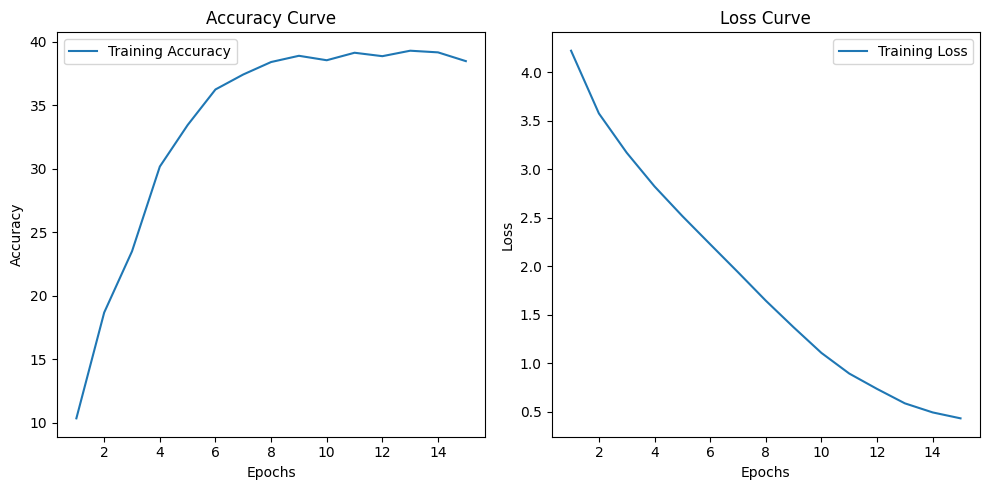

Average Train Accuracy: 33.36%
Average Train Loss: 1.8505089393870036


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from random import randrange
import matplotlib.pyplot as plt

tranform_train = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])
tranform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = torchvision.datasets.CIFAR100("data/", train=True, download=True, transform=tranform_train)

val_size = 10000
train_size = len(train) - val_size  # 40000

train, val = random_split(train, [train_size, val_size])

test = torchvision.datasets.CIFAR100("data/", train=False, download=True, transform=tranform_test)

train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, num_workers=2)


class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5)  # dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = VGG16_NET()
model = model.to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Lists to store accuracy and loss values
train_accuracy = []
train_loss = []
# test_accuracy = []
# test_loss = []

# number of times the entire training dataset will be passed through the model.
num_epochs = 15

# outer loop iterates over the specified number of epochs.decide the num_epochs, I tried 5
for epoch in range(num_epochs):
    # Initializes to keep track of the cumulative loss for each epoch
    loss_var = 0

    # iterates over the batches of data provided by the train_loader. It provides both the input images and their corresponding labels
    for idx, (images, labels) in enumerate(train_loader):
        # Moves the input images and labels to the device (e.g., GPU) specified by device
        images = images.to(device=device)
        labels = labels.to(device=device)
        # Forward Pass
        # Clears the gradients of all optimized parameters.
        # This is necessary before computing the gradients for a new batch.
        optimizer.zero_grad()
        # Performs a forward pass of the input images through the model to obtain the predicted scores or logits
        scores = model(images)
        # Computes the loss between the predicted scores and the actual labels using a predefined loss function
        loss = criterion(scores, labels)
        # Backpropagates the gradients of the loss with respect to the model's parameters.
        # This step calculates the gradients of the loss function with respect to each parameter using the chain rule of derivatives
        loss.backward()
        # performs the optimization by adjusting the weights and biases of the model using the chosen optimizer's update rule
        optimizer.step()
        # Accumulates the loss value for the current batch to loss_var, converting it to a Python scalar using loss.item()
        loss_var += loss.item()

    # Prints the current epoch number and the average loss for the epoch, which is obtained by dividing
    # the cumulative loss (loss_var) by the total number of batches (len(train_loader))
    # Computes average loss for the epoch
    average_train_loss = loss_var / len(train_loader)
    train_loss.append(average_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f"Loss at epoch {epoch + 1} || {loss_var / len(train_loader)}")

    # disable gradient computation during the evaluation phase
    with torch.no_grad():
        # keep track of the number of correct predictions and the total number of samples evaluated
        correct = 0
        samples = 0

        #  iterates over the batches of data provided by the val_loader
        for idx, (images, labels) in enumerate(val_loader):
            # Moves the input images and labels to the specified device
            images = images.to(device=device)
            labels = labels.to(device=device)

            # Passes the input images through the trained model to obtain the predicted scores
            outputs = model(images)
            # Finds the predicted class labels by selecting the class with the highest score using the max() function along dimension 1
            _, preds = outputs.max(1)

            # Computes the number of correct predictions by comparing the predicted labels (preds)
            # with the true labels (labels) and summing the occurrences of correct predictions
            correct += (preds == labels).sum()
            # Updates the total number of evaluated samples by adding the batch size (preds.size(0)).
            samples += preds.size(0)

        # calculates the accuracy and average loss
        average_train_accuracy = float(correct) / float(samples) * 100
        train_accuracy.append(average_train_accuracy)
        # calculates the accuracy by dividing the number of correct predictions (correct)
        # by the total number of evaluated samples (samples), and then multiplies by 100 to get a percentage
        print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

torch.save(model.state_dict(), "cifar100_vgg16_model.pt")  # SAVES THE TRAINED MODEL

model = VGG16_NET()
model.load_state_dict(torch.load("/content/cifar100_vgg16_model.pt"))  # loads the trained model
model.eval()

correct = 0
total = 0
test_loss_val = 0

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # compute the loss
        loss = criterion(outputs, labels)
        test_loss_val += loss.item()

accuracy = 100 * correct / total
average_loss = test_loss_val / len(test_loader)
print('Test Accuracy: {:.2f}%' .format(accuracy))
print('Test Loss: {:.2f}%' .format(average_loss))

# Plotting Accuracy and Loss
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.savefig('accuracy_loss_plot.png')  # Save the plot as an image
plt.show()

# Calculate average accuracy and loss
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_train_loss = sum(train_loss) / len(train_loss)

print(f"Average Train Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Train Loss: {average_train_loss}")
